In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/santander-customer-transaction-prediction-dataset/train.csv
/kaggle/input/santander-customer-transaction-prediction-dataset/test.csv


In [4]:
pd.options.display.max_info_rows = 201
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style(style = "darkgrid")
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, precision_recall_curve
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbpipeline


In [5]:
# ingest the dataset

raw_dataset = pd.read_csv("../input/santander-customer-transaction-prediction-dataset/train.csv")
raw_dataset.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [6]:
# See the rough distribution of data 
raw_dataset.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [7]:
#See number of nulls 
raw_dataset.info(verbose = True, show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 202 columns):
 #    Column   Non-Null Count   Dtype  
---   ------   --------------   -----  
 0    ID_code  200000 non-null  object 
 1    target   200000 non-null  int64  
 2    var_0    200000 non-null  float64
 3    var_1    200000 non-null  float64
 4    var_2    200000 non-null  float64
 5    var_3    200000 non-null  float64
 6    var_4    200000 non-null  float64
 7    var_5    200000 non-null  float64
 8    var_6    200000 non-null  float64
 9    var_7    200000 non-null  float64
 10   var_8    200000 non-null  float64
 11   var_9    200000 non-null  float64
 12   var_10   200000 non-null  float64
 13   var_11   200000 non-null  float64
 14   var_12   200000 non-null  float64
 15   var_13   200000 non-null  float64
 16   var_14   200000 non-null  float64
 17   var_15   200000 non-null  float64
 18   var_16   200000 non-null  float64
 19   var_17   200000 non-null  float64
 20   va

In [8]:
# Get binary class distribution
raw_dataset["target"].value_counts(dropna = False)/raw_dataset.shape[0]

#highly skewed distribution

0    0.89951
1    0.10049
Name: target, dtype: float64

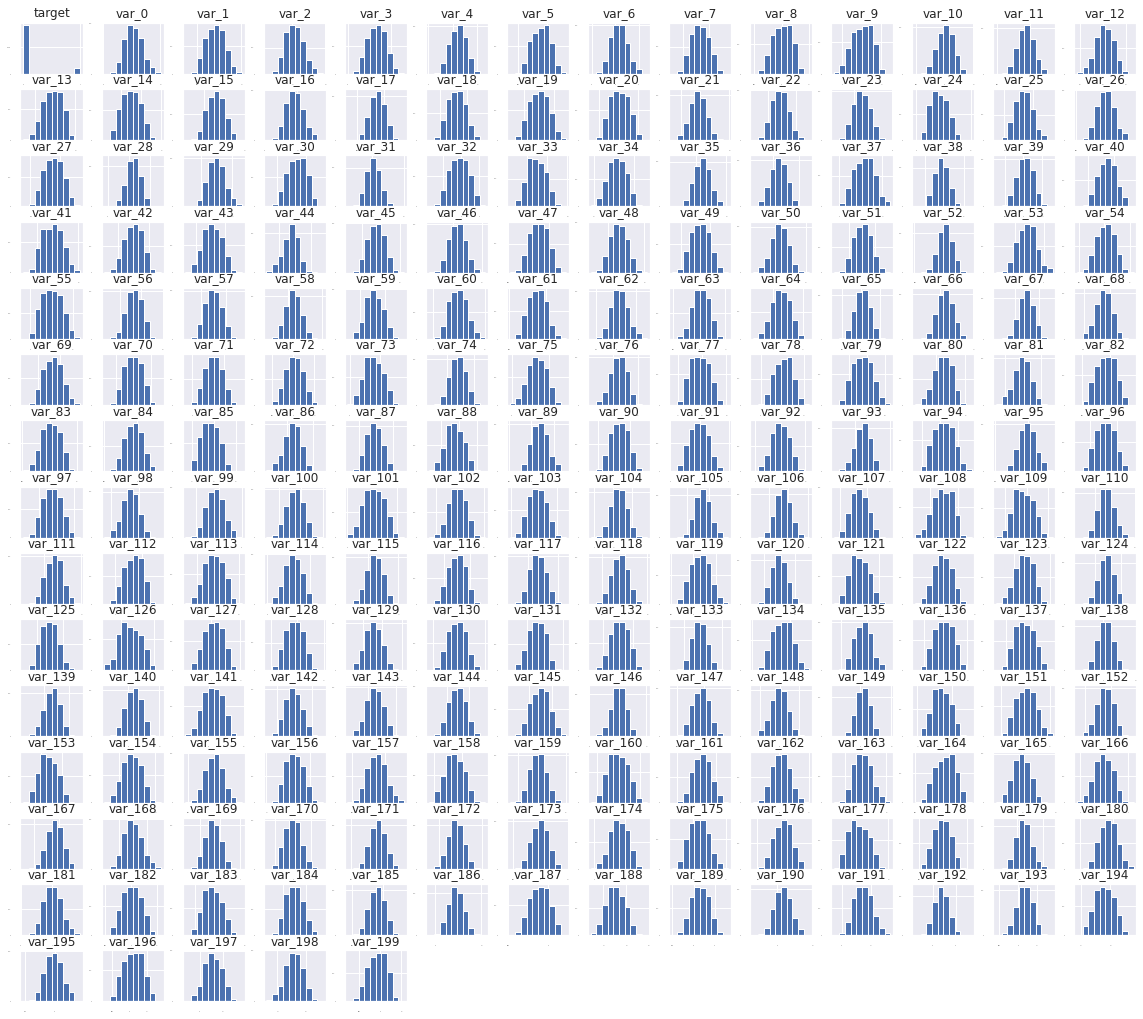

In [9]:
# #get distribution
raw_dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize = (20,18));

# # Except target, most of the variables are normally distributed

In [ ]:
# get box and whisker plots 

# plt.boxplot(raw_dataset, labels = list(raw_dataset.columns));


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  


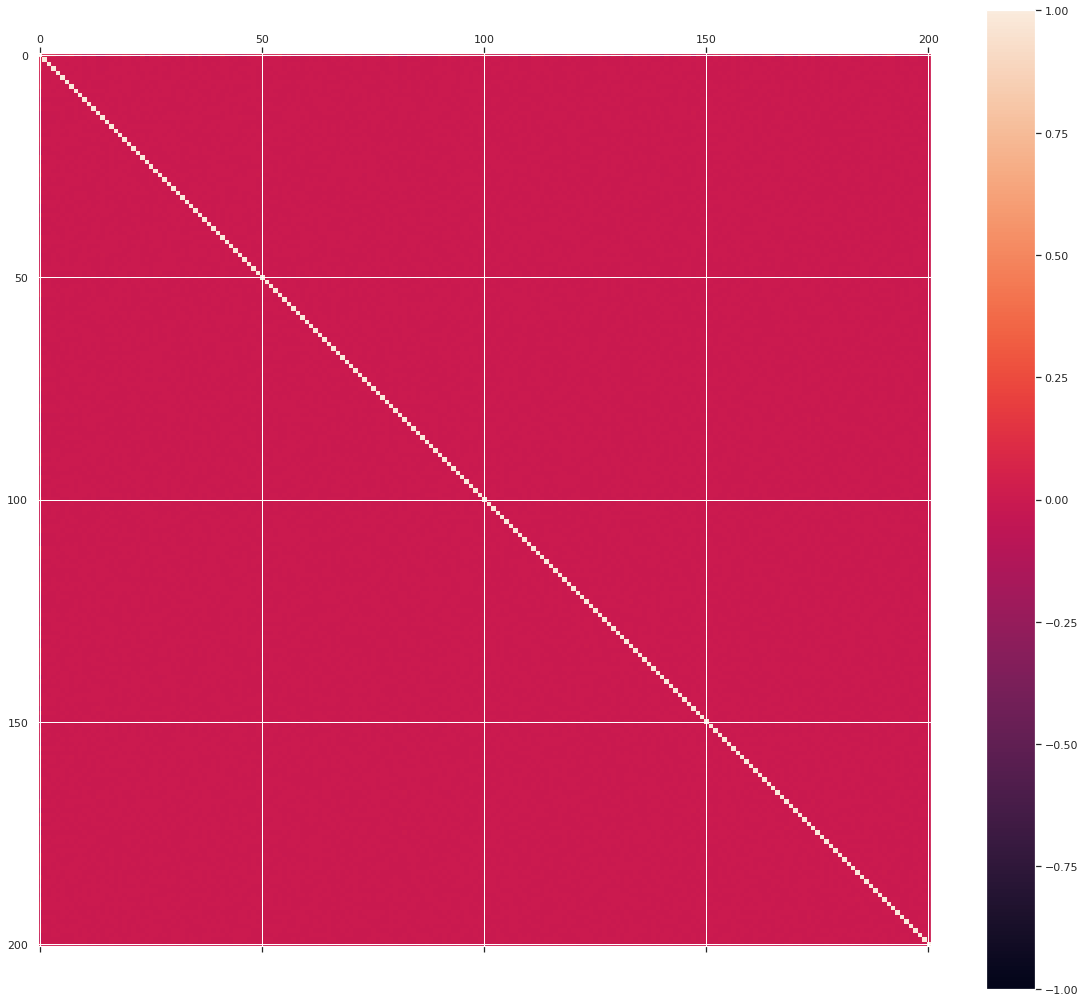

In [10]:
# # corr matrix 

fig = plt.figure(figsize = (20,18))
ax = fig.add_subplot(111)
cax = ax.matshow(raw_dataset.corr(), vmin=-1, vmax=1, interpolation='none')
fig.colorbar(cax)
plt.show()

# #low/no correlation between attributes

In [11]:
# #Get correlation matrix

corr_matrix = raw_dataset.corr().abs()

# #low correlation between attributes

In [14]:
# # Check if any cols are more correlated 

correlation_treshold = 0.6

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
correlated_cols = [column for column in upper.columns if any(upper[column] > correlation_treshold)]

correlated_cols

[]

In [13]:
# Separate features and target

X = raw_dataset.drop(columns = ["ID_code", "target"])
y = raw_dataset["target"]

In [15]:
# set random seed

random_seed = 42

In [16]:
# seperate a training and testing set 

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,stratify=y,random_state=random_seed)

# Merge test df to get stratified samples 

training_dataset =  X_train.merge(y_train.to_frame(), left_index=True, right_index=True)
training_dataset.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199,target
59864,9.6933,-2.4255,10.9351,4.7861,11.4639,-1.9561,5.0136,10.0195,-2.6873,9.6778,...,4.4830,-0.5747,6.0496,12.8398,0.1474,11.3712,10.4911,16.7409,2.5494,0
128990,9.0945,-3.4072,8.3412,4.1683,12.9005,-1.0546,6.2069,19.1833,4.4601,5.8213,...,3.8164,3.5985,0.6460,18.8068,0.3827,-0.7915,10.0788,21.9431,-15.6626,0
27890,4.8086,1.7615,6.4716,7.1207,12.7379,-14.5603,4.0059,12.2351,-1.9882,8.8706,...,11.1094,3.9747,6.8936,14.9802,-1.5616,-0.1406,8.2615,16.7520,-1.6382,0
143056,9.4214,2.7131,15.6923,4.3296,11.4713,-8.3192,5.8888,20.7898,1.9752,7.3627,...,5.4222,1.0913,6.6895,19.8162,0.0387,-3.3236,8.2064,16.7587,-28.6671,0
4271,9.9651,1.1076,11.4266,6.3137,9.6954,-6.0839,3.8754,17.1563,2.4501,8.9588,...,7.7861,3.1748,-1.7787,22.2981,-2.8483,10.3890,7.7566,17.5830,-15.5327,0


In [17]:
# Get a stratified sampling 1% of the data to run algos

def get_sampled_data(dataset, sample_size, strat_col):
    sampled_data = dataset.groupby(strat_col, group_keys=False).apply(lambda x: x.sample(frac=sample_size))
    return sampled_data


In [18]:
sampled_dataset = get_sampled_data(training_dataset, 0.1, "target")

X_train_sample = sampled_dataset.drop(columns = ["target"])
y_train_sample = sampled_dataset["target"]
X_train_sample.shape, y_train_sample.shape

((14000, 200), (14000,))

In [21]:
#check distribution of classes in sampled dataset
y_train_sample.value_counts()/y_train_sample.shape[0]

0    0.8995
1    0.1005
Name: target, dtype: float64

In [22]:
# Initialize a stratified k fold validation instance

num_folds = 10
skf = StratifiedKFold(n_splits = num_folds, shuffle = True, random_state = random_seed)

In [23]:
# # Get a baseline benchmark using Zero Rule Classification

# def zero_rule_classification(train, test):
#     prediction = stats.mode(train)[0][0]
#     predicted = [prediction for i in range(len(test))]
#     return predicted

# splits = skf.split(X_train_sample, y_train_sample)
# acc_list = list()

# for train_index, test_index in splits:
#     train_y_zero = y_train_sample[train_index]
#     test_y_zero = y_train_sample[test_index]
#     predicted = zero_rule_classification(train_y_zero, test_y_zero)
#     acc_list.append(
#         accuracy_score(test_y_zero, predicted)
#     )
    
# print("benchmark zero classification mean accuracy: {mean_acc}".format(mean_acc = round(np.mean(acc_list),4)))
        

In [24]:
# Get a list of candidate algos that we want to test

models = list()
models.append(
    ("LogisticRegression", LogisticRegression())
)
models.append(
    ("LinearDiscriminantAnalysis", LinearDiscriminantAnalysis())
)
models.append(
    ("SGDClassifier", SGDClassifier())
)
models.append(
    ("KNeighborsClassifier", KNeighborsClassifier())
)
models.append(
    ("DecisionTreeClassifier", DecisionTreeClassifier())
)
models.append(
    ("GaussianNB", GaussianNB())
)
models.append(
    ("SVC", SVC())
)
models.append(
    ("RandomForestClassifier", RandomForestClassifier())
)

In [25]:
# Get an intial testing harness for candidate algos NO SCALING

results = list()
model_name = list()
scoring = "accuracy"

for name, model in models:
    c_time = time.time()
    skfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = random_seed)
    cv_results = cross_val_score(model, X_train_sample, y_train_sample, cv = skfold, scoring= scoring)
    results.append(cv_results)
    model_name.append(name)
    duration = time.time() - c_time
    print(
        "{name} avg. accuracy: {mean} std: {std} time taken: {duration}s".format(
            name = name,
            mean = round(cv_results.mean(),3),
            std = round(cv_results.std(),3),
            duration = round(duration,0)
    ))
    
# Pass 1 : LR The train set failed to converge meaning the the input data is not scaled properly and CART and SGD have bigger spead of scores 

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression avg. accuracy: 0.91 std: 0.005 time taken: 4.89265513420105s
LinearDiscriminantAnalysis avg. accuracy: 0.912 std: 0.004 time taken: 5.366745233535767s
SGDClassifier avg. accuracy: 0.876 std: 0.057 time taken: 16.268197774887085s
KNeighborsClassifier avg. accuracy: 0.899 std: 0.001 time taken: 5.993785858154297s
DecisionTreeClassifier avg. accuracy: 0.826 std: 0.008 time taken: 129.5872232913971s
GaussianNB avg. accuracy: 0.92 std: 0.003 time taken: 0.5083534717559814s
SVC avg. accuracy: 0.9 std: 0.0 time taken: 139.0322253704071s
RandomForestClassifier avg. accuracy: 0.9 std: 0.0 time taken: 458.07336473464966s


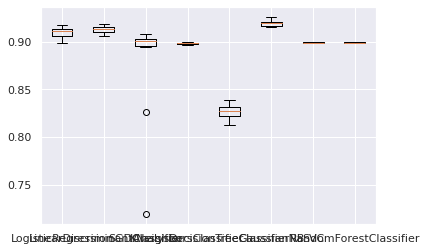

In [35]:
# Plot the distribution of the algos

plt.boxplot(results, labels = model_name);

In [39]:
# Keep top 3 models
initial_performance = list(zip(model_name, results))
initial_performance.sort(key = lambda x: x[1].mean(), reverse = True)
models_to_keep = [model[0] for model in initial_performance][:3]
models = [model for model in models if model[0] in models_to_keep]
models

[('LogisticRegression', LogisticRegression()),
 ('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis()),
 ('GaussianNB', GaussianNB())]

In [40]:
# Add a scaling step

results = list()
model_name = list()
scoring = "accuracy"

for name, model in models:
    c_time = time.time()
    skfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = random_seed)
    model_pipeline = Pipeline([
        ("scaler", StandardScaler()),(name, model)
    ])
    
    cv_results = cross_val_score(model_pipeline, X_train_sample, y_train_sample, cv = skfold, scoring= scoring)
    results.append(cv_results)
    model_name.append(name)
    duration = time.time() - c_time
    print(
        "{name} avg. accuracy: {mean} std: {std} time taken: {duration}s".format(
            name = name,
            mean = round(cv_results.mean(),3),
            std = round(cv_results.std(),3),
            duration = round(duration,0)
    ))

# Pass 2 : Scale the input 
#LR converged after scaling

LogisticRegression avg. accuracy: 0.912 std: 0.004 time taken: 1.0s
LinearDiscriminantAnalysis avg. accuracy: 0.912 std: 0.004 time taken: 6.0s
GaussianNB avg. accuracy: 0.92 std: 0.003 time taken: 1.0s


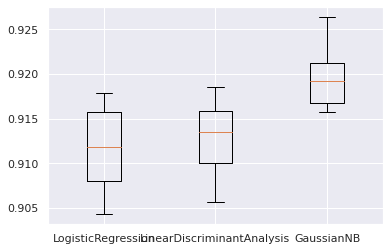

In [41]:
# Plot the distribution of the algos

plt.boxplot(results, labels = model_name);

In [42]:
# Keep top 2 models
second_performance = list(zip(model_name, results))
second_performance.sort(key = lambda x: x[1].mean(), reverse = True)
models_to_keep = [model[0] for model in initial_performance][:2]
models = [model for model in models if model[0] in models_to_keep]
models

[('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis()),
 ('GaussianNB', GaussianNB())]

In [ ]:
 # Tuning LR with specific hyperparameters

# scaler = StandardScaler()
# scaler = scaler.fit(X_train_sample)
# rescaledX = scaler.transform(X_train_sample)

# solvers = ['newton-cg', 'lbfgs', 'liblinear']
# max_iter = [200, 300]
# c_values = [1.0, 0.1, 0.01, 0.001]

# model_params = dict(solver = solvers, max_iter = max_iter, C = c_values)
# skfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = random_seed)
# model = LogisticRegression()
# grid = GridSearchCV(model, param_grid = model_params, cv = skfold, scoring = scoring)
# grid_result = grid.fit(rescaledX, y_train_sample)
# print("Best {score} using {params}".format(
#     score = grid_result.best_score_,
#     params = grid_result.best_params_
#     ))

# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))
    
# Best 0.9077999999999999 using {'C': 0.01, 'max_iter': 200, 'solver': 'newton-cg'}

In [43]:
# Hyperparameter tuning on larger sampled dataset
sampled_dataset = get_sampled_data(training_dataset, 0.6, "target")

X_train_sample = sampled_dataset.drop(columns = ["target"])
y_train_sample = sampled_dataset["target"]
X_train_sample.shape, y_train_sample.shape

((84000, 200), (84000,))

In [44]:
# Tuning NB with specific hyperparameters

scaler = StandardScaler()
scaler = scaler.fit(X_train_sample)
rescaledX = scaler.transform(X_train_sample)

var_smoothing =  np.logspace(0,-9, num=100)
    
model_params = dict(var_smoothing = var_smoothing)
skfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = random_seed)
model = GaussianNB()
grid = GridSearchCV(model, param_grid = model_params, cv = skfold, scoring = scoring)
grid_result = grid.fit(rescaledX, y_train_sample)
print("Best {score} using {params}".format(
    score = grid_result.best_score_,
    params = grid_result.best_params_
    ))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# Best 0.9165000000000001 using {'var_smoothing': 0.02848035868435802}

Best 0.9218452380952382 using {'var_smoothing': 1.873817422860383e-05}
0.899595 (0.000095) with: {'var_smoothing': 1.0}
0.899690 (0.000133) with: {'var_smoothing': 0.8111308307896871}
0.900000 (0.000244) with: {'var_smoothing': 0.657933224657568}
0.900714 (0.000388) with: {'var_smoothing': 0.533669923120631}
0.902107 (0.000586) with: {'var_smoothing': 0.43287612810830584}
0.903881 (0.000772) with: {'var_smoothing': 0.3511191734215131}
0.906143 (0.000566) with: {'var_smoothing': 0.2848035868435802}
0.908786 (0.000917) with: {'var_smoothing': 0.23101297000831597}
0.911476 (0.001547) with: {'var_smoothing': 0.1873817422860384}
0.913881 (0.001814) with: {'var_smoothing': 0.15199110829529336}
0.915750 (0.001536) with: {'var_smoothing': 0.12328467394420659}
0.917536 (0.001589) with: {'var_smoothing': 0.1}
0.918940 (0.001477) with: {'var_smoothing': 0.08111308307896872}
0.919893 (0.001777) with: {'var_smoothing': 0.0657933224657568}
0.920357 (0.001709) with: {'var_smoothing': 0.05336699231206

In [45]:
# Tuning LD with specific hyperparameters

scaler = StandardScaler()
scaler = scaler.fit(X_train_sample)
rescaledX = scaler.transform(X_train_sample)

solver = ['svd', 'lsqr', 'eigen']
model_params = dict(solver=solver)

skfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = random_seed)
model = LinearDiscriminantAnalysis()
grid = GridSearchCV(model, param_grid = model_params, cv = skfold, scoring = scoring)
grid_result = grid.fit(rescaledX, y_train_sample)
print("Best {score} using {params}".format(
    score = grid_result.best_score_,
    params = grid_result.best_params_
    ))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
# Best 0.9127000000000001 using {'solver': 'svd'}

Best 0.9145476190476189 using {'solver': 'svd'}
0.914548 (0.001501) with: {'solver': 'svd'}
0.914548 (0.001501) with: {'solver': 'lsqr'}
0.914548 (0.001501) with: {'solver': 'eigen'}


In [46]:
#Get the full dataset to run on tuned parameters
sampled_dataset = get_sampled_data(training_dataset, 1, "target")

X_train_sample = sampled_dataset.drop(columns = ["target"])
y_train_sample = sampled_dataset["target"]

In [48]:
# Check model on test data
scaler  = StandardScaler()
scaler = scaler.fit(X_train_sample)
X_train_scaled = scaler.transform(X_train_sample)
X_test_scaled = scaler.transform(X_test)

model = GaussianNB(var_smoothing= 1.873817422860383e-05)
model.fit(X_train_scaled, y_train_sample)
predictions = model.predict(X_test_scaled)
model_probs = model.predict_proba(X_test_scaled)
precision, recall, thresholds = precision_recall_curve(y_test, model_probs[:,1])

print("Model : {name}".format(name = name))
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
    

Model : GaussianNB
0.9198
[[53085   886]
 [ 3926  2103]]
              precision    recall  f1-score   support

           0       0.93      0.98      0.96     53971
           1       0.70      0.35      0.47      6029

    accuracy                           0.92     60000
   macro avg       0.82      0.67      0.71     60000
weighted avg       0.91      0.92      0.91     60000

